In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matlab.engine

%matplotlib inline

In [21]:
fs = 1000.

t = np.arange(2 * fs) / fs
f = 10.
x = np.sin(2*np.pi*f*t) + 5 * np.exp(-(t-1)**2/0.1)

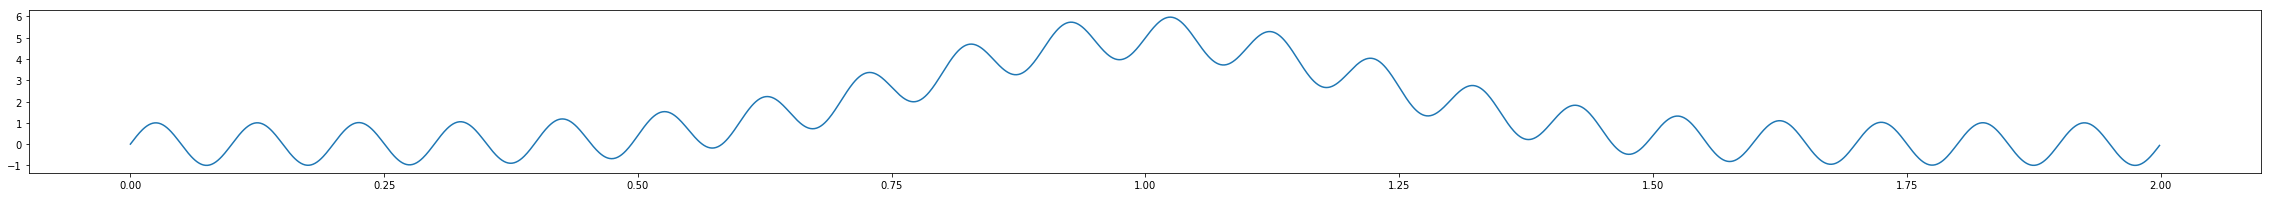

In [3]:
plt.figure(figsize=(40,3))
plt.plot(t, x)

## First thing to check: do we get same results using MATLAB?

In [4]:
coefs_py = pywt.cwt(x, 1, 'cmor1.0-1.0')

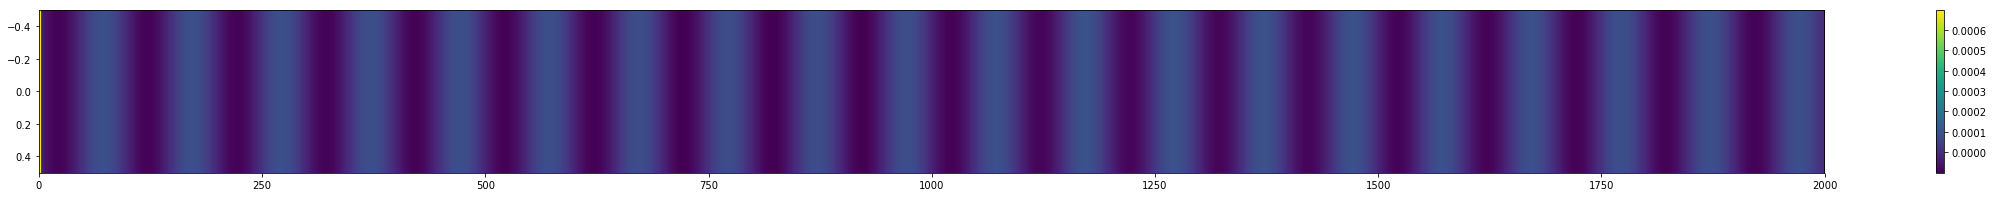

In [5]:
plt.figure(figsize=(40,3));
plt.imshow(np.real(coefs_py[0]), aspect="auto");
plt.colorbar()

In [6]:
with matlab.engine.start_matlab() as eng:
    row_mat = matlab.double(list(x))
    coefs = np.round(np.asarray(eng.cwt(row_mat, matlab.double([1.]), 'cmor1-1', 0.001)), decimals=5)

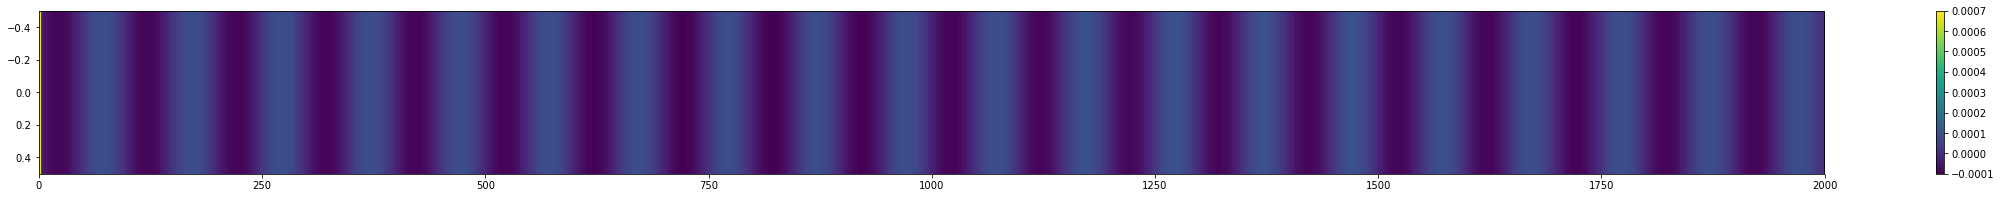

In [7]:
plt.figure(figsize=(40,3));
plt.imshow(np.real(coefs), aspect="auto");
plt.colorbar();

From the code in pywt the operations performed in the two cases are similar. We have first the integration on the $\Psi$ mother wavelet and then the convolution with the vector for which we compute the wavelet coefficients

Let's try to see what kind of animal is the wavelet function used

In [8]:
dt = 0.001  # 1 kHz sampling
frequencies = pywt.scale2frequency('cmor3.5-1.5', 1) / dt
frequencies

1500.0

We use in our analysis the **complex Morlet wavelet**. This corresponds to 

$$\Psi(t) = \frac{1}{\sqrt{\pi B}}\exp\left[-\frac{t^2}{B}\right]\exp\left[j 2 \pi C t\right] $$

It is the product between a gaussian and a sinusoidal function. The parameters $B$ and $C$ are chosen by user. The parameter $C$ corresponds to the oscillation frequency of the wavelet, and determines the frequency of the filter. In the example given, pywt.scale2frequency corresponds to the central frequency, given a scale, for a default sampling frequency of 1 Hz. This value must be divided by the sampling period to obtain the effective frequency of the output we get from the convolution.

In the example given above, for dt=1 ms and a parameter C=1.5 we obtain a frequency of 1.5 kHz. This leads to aliasing phenomena, we will select scales which are lower than Nyquist frequency

In [9]:
frequencies = pywt.scale2frequency('cmor2-0.5', 1) / dt
frequencies

500.0

What's going on? 

To understand what the parameters $B$ and $C$ stands for, we should go to the frequency domain, and express there the mother wavelet. 

$$ \mathcal{F}(\Psi)(\omega) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{+\infty} \frac{1}{\sqrt{\pi B}}\exp\left[-\frac{t^2}{B}\right]\exp\left[j 2 \pi C t\right] \exp\left[-j\omega t \right] dt $$
$$ \mathcal{F}(\Psi)(\omega) = \frac{1}{\sqrt{2\pi}\sqrt{\pi B}}\int_{-\infty}^{+\infty} \exp\left[-\frac{t^2}{B}\right]\exp\left[-2j\frac{\omega - 2 \pi C}{2} t\right]  dt $$
By completing the square, this corresponds to
$$ \mathcal{F}(\Psi)(\omega) = \frac{1}{\sqrt{2\pi^2 B}} \exp\left[-\frac{(\omega - 2\pi C)^2B^2}{4} \right]\int_{-\infty}^{+\infty} \exp\left[-\frac{1}{B}\left(t + j\frac{\omega - 2\pi C}{2}B\right)^2 \right] dt $$
The second term is an analytical function. Given the rectangular path in the complex plane, we get zero contribute from the integral on the vertical lines. We obtain the horizontal path only, which corresponds to the gaussian integral on the real line. 
$$ \mathcal{F}(\Psi)(\omega) = \frac{1}{\sqrt{2\pi^2 B}} \exp\left[-\frac{(\omega - 2\pi C)^2B^2}{4} \right] \sqrt{\pi B} \propto  \exp\left[-\frac{(\omega - 2\pi C)^2}{(2/B)^2} \right] $$

We have built a filter in such a way that it has a gaussian shape

$f_c = C$  
$\sigma_\omega = \frac{2}{B},\ 2\pi f_{band} = \frac{2}{B},\ B = \frac{1}{\pi f_{band}} = \frac{T_{band}}{\pi}$, bandwidth

$\sigma_\omega$ in particular we have that this filter has a variance of 

# Understand the meaning of this variance

Last effort - we consider the relation with the scale - what happen for different values of the variance. 
We get, in the frequency domain, a mother wavelet which is equivalent to 
$$\frac{1}{\sqrt{2\pi}} \exp \left[-\frac{(a \omega - 2\pi C)^2}{(2/B)^2} \right]$$

$$\frac{1}{\sqrt{2\pi}} \exp \left[-\frac{(\omega - 2\pi C/a)^2}{4/(Ba)^2} \right]$$

This means that the central frequency is shrinked by a factor a. Moreover what we get is the following. We want the variance to be not to high. The greater is $B$, the higher becomes the indetermination in the temporal domain, but the filter is lower undetermined in the frequency domain. We make an example in the following, with $B=20$

Continuous wavelet will be evaluated over the range [-8.0, 8.0]


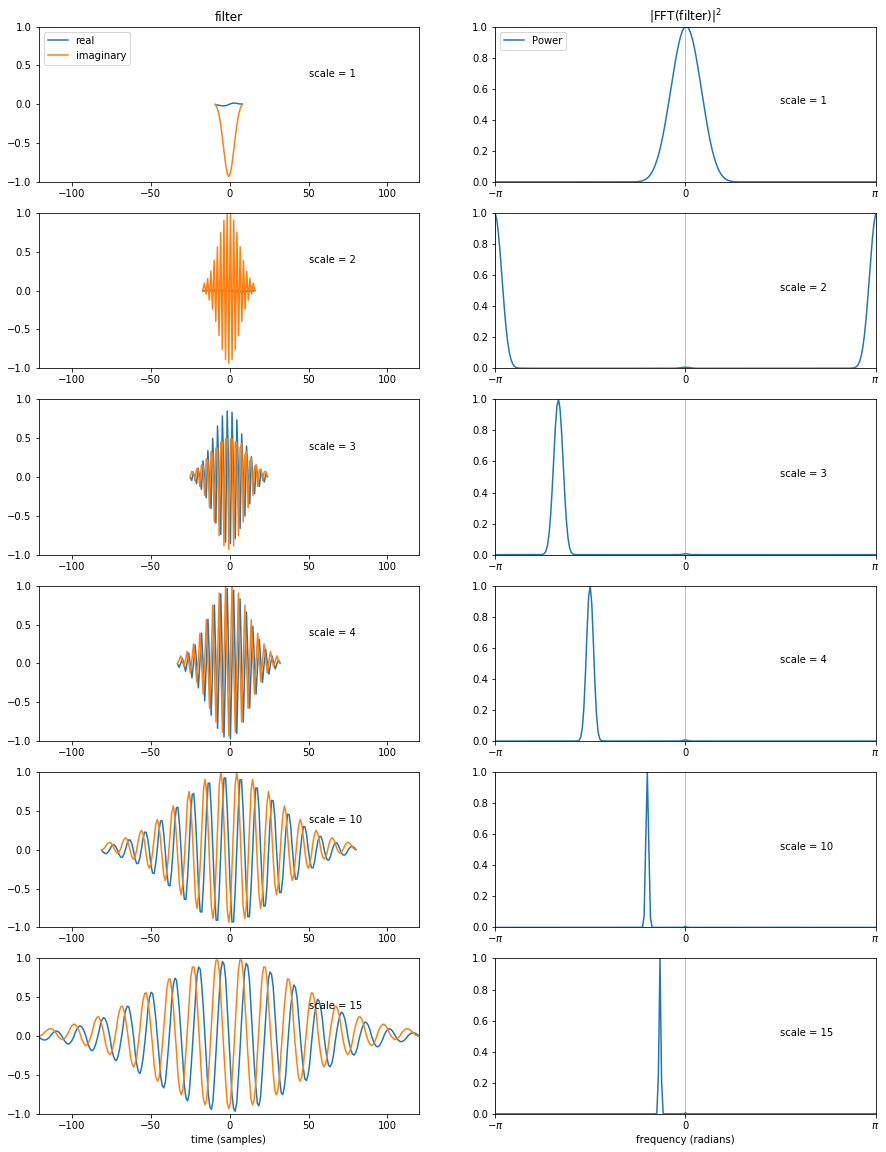

In [10]:
wav = pywt.ContinuousWavelet('cmor20-1')

# print the range over which the wavelet will be evaluated
print("Continuous wavelet will be evaluated over the range [{}, {}]".format(
    wav.lower_bound, wav.upper_bound))

width = wav.upper_bound - wav.lower_bound

scales = [1, 2, 3, 4, 10, 15]

max_len = int(np.max(scales)*width + 1)
t = np.arange(max_len)
fig, axes = plt.subplots(len(scales), 2, figsize=(15, 20))
for n, scale in enumerate(scales):

    # The following code is adapted from the internals of cwt
    int_psi, x = pywt.integrate_wavelet(wav, precision=10)
    step = x[1] - x[0]
    j = np.floor(
        np.arange(scale * width + 1) / (scale * step))
    if np.max(j) >= np.size(int_psi):
        j = np.delete(j, np.where((j >= np.size(int_psi)))[0])
    j = j.astype(np.int)

    # normalize int_psi for easier plotting
    int_psi /= np.abs(int_psi).max()

    # discrete samples of the integrated wavelet
    filt = int_psi[j][::-1]

    # The CWT consists of convolution of filt with the signal at this scale
    # Here we plot this discrete convolution kernel at each scale.

    nt = len(filt)
    t = np.linspace(-nt//2, nt//2, nt);
    axes[n, 0].plot(t, filt.real, t, filt.imag);
    axes[n, 0].set_xlim([-max_len//2, max_len//2]);
    axes[n, 0].set_ylim([-1, 1]);
    axes[n, 0].text(50, 0.35, 'scale = {}'.format(scale));

    f = np.linspace(-np.pi, np.pi, max_len);
    filt_fft = np.fft.fftshift(np.fft.fft(filt, n=max_len));
    filt_fft /= np.abs(filt_fft).max();
    axes[n, 1].plot(f, np.abs(filt_fft)**2);
    axes[n, 1].set_xlim([-np.pi, np.pi]);
    axes[n, 1].set_ylim([0, 1]);
    axes[n, 1].set_xticks([-np.pi, 0, np.pi]);
    axes[n, 1].set_xticklabels([r'$-\pi$', '0', r'$\pi$']);
    axes[n, 1].grid(True, axis='x');
    axes[n, 1].text(np.pi/2, 0.5, 'scale = {}'.format(scale));

axes[n, 0].set_xlabel('time (samples)');
axes[n, 1].set_xlabel('frequency (radians)');
axes[0, 0].legend(['real', 'imaginary'], loc='upper left');
axes[0, 1].legend(['Power'], loc='upper left');
axes[0, 0].set_title('filter');
axes[0, 1].set_title(r'|FFT(filter)|$^2$');

Higher variance instead corresponds to local phenomena, that is the reason why we use wavelet transform

** we will make this choice in the experiments ** but we leave to user the possibility of explore other mother wavelets

Continuous wavelet will be evaluated over the range [-8.0, 8.0]


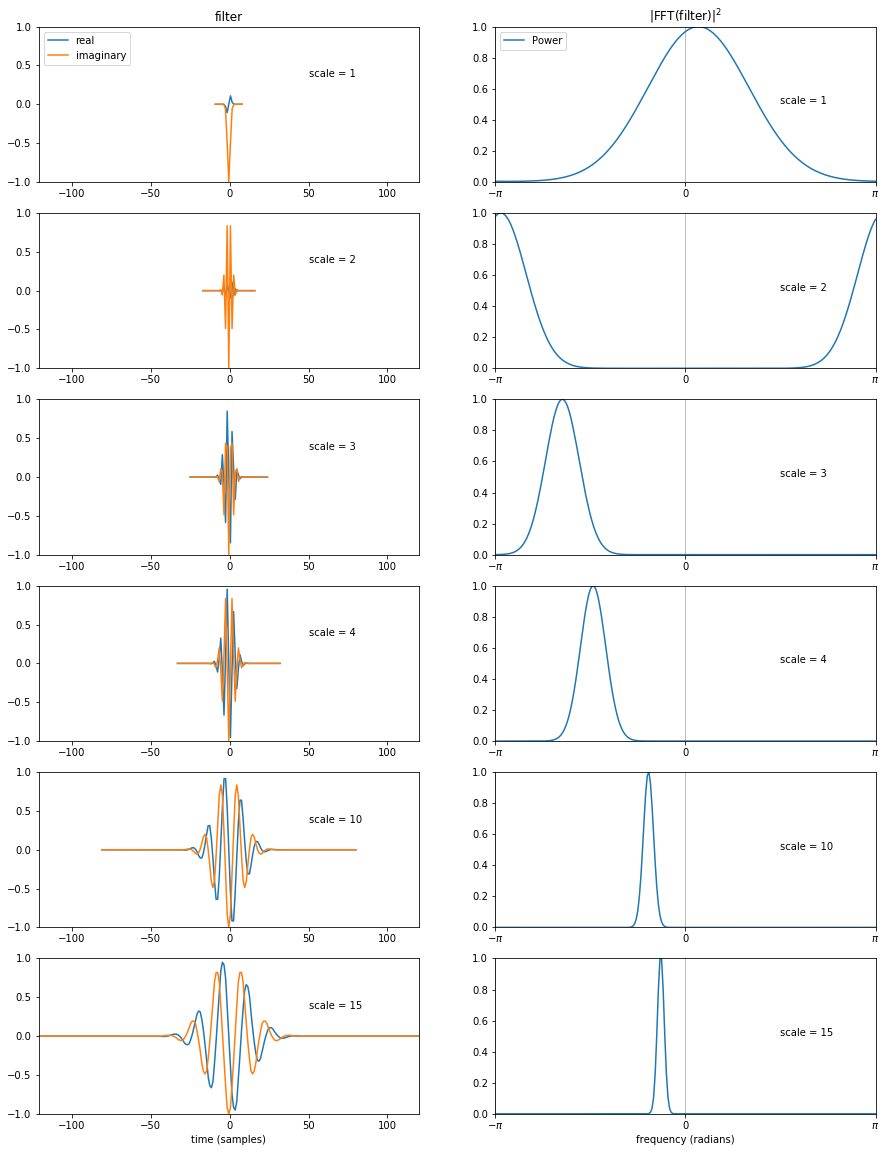

In [11]:
wav = pywt.ContinuousWavelet('cmor1.5-1.')

# print the range over which the wavelet will be evaluated
print("Continuous wavelet will be evaluated over the range [{}, {}]".format(
    wav.lower_bound, wav.upper_bound))

width = wav.upper_bound - wav.lower_bound

scales = [1, 2, 3, 4, 10, 15]

max_len = int(np.max(scales)*width + 1)
t = np.arange(max_len)
fig, axes = plt.subplots(len(scales), 2, figsize=(15, 20))
for n, scale in enumerate(scales):

    # The following code is adapted from the internals of cwt
    int_psi, x = pywt.integrate_wavelet(wav, precision=10)
    step = x[1] - x[0]
    j = np.floor(
        np.arange(scale * width + 1) / (scale * step))
    if np.max(j) >= np.size(int_psi):
        j = np.delete(j, np.where((j >= np.size(int_psi)))[0])
    j = j.astype(np.int)

    # normalize int_psi for easier plotting
    int_psi /= np.abs(int_psi).max()

    # discrete samples of the integrated wavelet
    filt = int_psi[j][::-1]

    # The CWT consists of convolution of filt with the signal at this scale
    # Here we plot this discrete convolution kernel at each scale.

    nt = len(filt)
    t = np.linspace(-nt//2, nt//2, nt);
    axes[n, 0].plot(t, filt.real, t, filt.imag);
    axes[n, 0].set_xlim([-max_len//2, max_len//2]);
    axes[n, 0].set_ylim([-1, 1]);
    axes[n, 0].text(50, 0.35, 'scale = {}'.format(scale));

    f = np.linspace(-np.pi, np.pi, max_len);
    filt_fft = np.fft.fftshift(np.fft.fft(filt, n=max_len));
    filt_fft /= np.abs(filt_fft).max();
    axes[n, 1].plot(f, np.abs(filt_fft)**2);
    axes[n, 1].set_xlim([-np.pi, np.pi]);
    axes[n, 1].set_ylim([0, 1]);
    axes[n, 1].set_xticks([-np.pi, 0, np.pi]);
    axes[n, 1].set_xticklabels([r'$-\pi$', '0', r'$\pi$']);
    axes[n, 1].grid(True, axis='x');
    axes[n, 1].text(np.pi/2, 0.5, 'scale = {}'.format(scale));

axes[n, 0].set_xlabel('time (samples)');
axes[n, 1].set_xlabel('frequency (radians)');
axes[0, 0].legend(['real', 'imaginary'], loc='upper left');
axes[0, 1].legend(['Power'], loc='upper left');
axes[0, 0].set_title('filter');
axes[0, 1].set_title(r'|FFT(filter)|$^2$');

# Test the function

We transform again the sine

In [12]:
from signalprocessing.wavelet_transform import CWTTransform

In [22]:
CWT = CWTTransform(fs)
scales = CWT.scales

[ 0.69393102+2.47065687j  0.84822335+2.4454388j   1.00378716+2.41034322j
 ..., -1.27673205+2.32332128j -1.12405715+2.37589009j
 -0.97151882+2.41840268j]


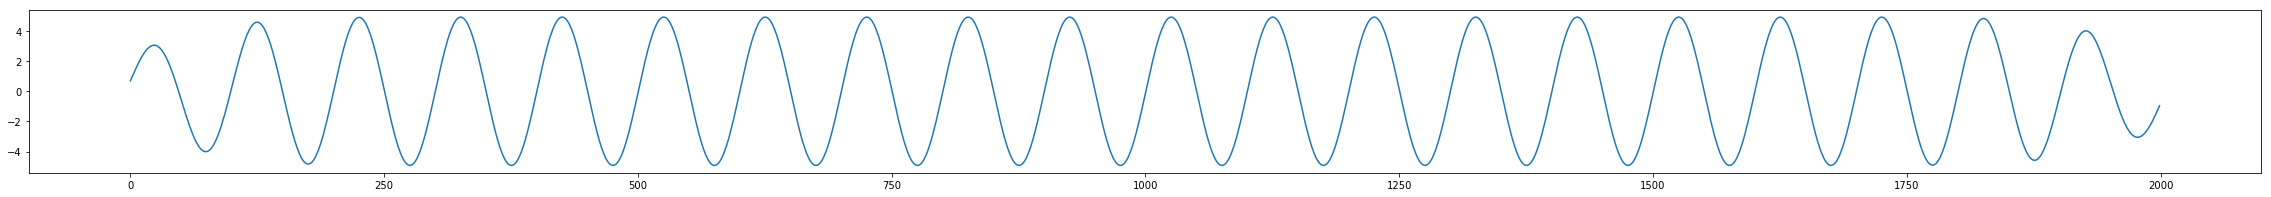

In [28]:
coefs = CWT.cwt(x, scales[5])
plt.figure(figsize=(40,3))
plt.plot(np.real(coefs))
print(coefs)

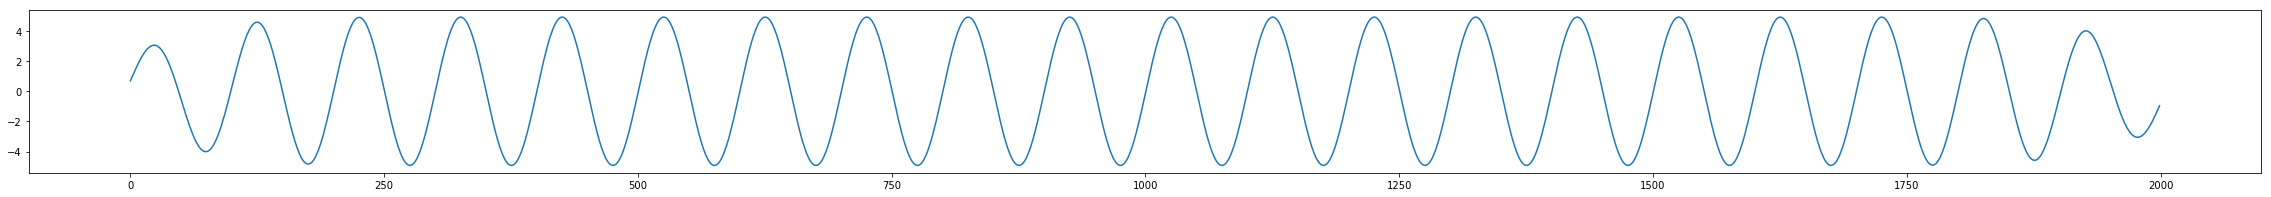

In [29]:
ww = pywt.cwt(data=x, scales=scales[5], wavelet="cmor1.5-1", sampling_period=0.001)[0][0]
plt.figure(figsize=(40,3))
plt.plot(np.real(ww))

In [30]:
pywt.scale2frequency("cmor1.5-1.", scales[5]) / 0.001

9.5

47.0


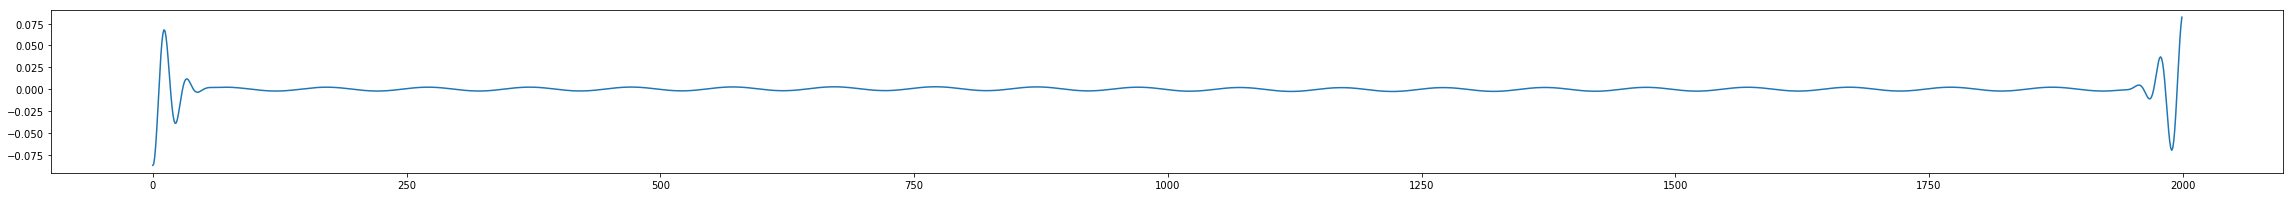

In [32]:
coefs = CWT.cwt(x, scales[30])
plt.figure(figsize=(40,3))
plt.plot(np.real(coefs))
print(CWT.fc[30])